In [1]:
!pip install or_gym

In [48]:
import or_gym
from or_gym.utils import create_env, assign_env_config

In [3]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torch.distributions import MultivariateNormal

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Transition = namedtuple('Transition',
#                        ('state', 'action', 'next_state', 'reward'))



In [5]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std):
        self.gamma = 0.99
        self.K_epochs = 80
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 256),
                nn.ELU(),
                nn.Linear(256, 256),
                nn.ELU(),
                nn.Linear(256, 2*action_dim),
                nn.ELU()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 256),
                nn.ELU(),
                nn.Linear(256, 256),
                nn.ELU(),
                nn.Linear(256, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, betas=betas)
        
    def forward(self):
        raise NotImplementedError
    
    def act(self, state, memory=None):
        
        output = self.actor(state)
       # print(output)
        action_mean = output[0,:3]
        cov_mat = torch.diag(output[0,3:]**2).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        if memory:
            memory.states.append(state)
            memory.actions.append(action)
            memory.logprobs.append(action_logprob)
        
        return action.detach()
    
    def evaluate(self, state, action):   
        

        output = self.actor(state)
        action_mean = output[:,:3]
        cov_mat = torch.diag_embed(output[:,3:]**2).to(device)
        
       # action_var = self.action_var.expand_as(action_mean)
        #cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

    def update(self,memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        #print(rewards)
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        #rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device), 1).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).to(device).detach()


        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            #ratios = torch.exp(logprobs - old_logprobs.detach())

            advantages = rewards - state_values.detach()
            action_loss = -(advantages.detach() * logprobs).mean()
            value_loss = advantages.pow(2).mean()
            loss = action_loss + value_loss

            # take gradient step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        

In [6]:
class A2C: 
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
      
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy.act(state, memory).cpu().data.numpy().flatten()
    
    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        #print(rewards)
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        #rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device), 1).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()   
            action_loss = -(advantages * logprobs).mean()
            loss = action_loss + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy:
      

In [27]:
class PPO:
    def __init__(self, state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        
        self.policy_old = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()
    
    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        #print(rewards)
        # Normalizing the rewards:
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device), 1).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())



def train_model(agent):

    memory = Memory()
    # logging variables
    reward_history = []
    running_reward = 0
    episode_reward = 0
    avg_length = 0
    time_step = 0
    # training loop
    for i_episode in range(1, max_episodes+1):
        state = env.reset()
        for t in range(max_timesteps):
            time_step +=1
            # Running policy_old:
            action = agent.select_action(state, memory)
            state, reward, done, _ = env.step(action)
            
            # Saving reward and is_terminals:
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            
            # update if its time
            if time_step % update_timestep == 0:
              # print('update')
                agent.update(memory)
                memory.clear_memory()
                time_step = 0
            running_reward += reward
            episode_reward += reward
            if done:
                break
        reward_history.append(episode_reward)
        episode_reward = 0
        # logging
        if i_episode % log_interval == 0:
            running_reward = int((running_reward/log_interval))
            print('Episode {} \t Avg reward: {}'.format(i_episode, running_reward))
            running_reward = 0
            avg_length = 0

    return reward_history
               

In [63]:
env = or_gym.make("InvManagement-v1")
env_config = {
    "L":[3, 5, 10],
    "p":2
}

In [64]:
assign_env_config(env,env_config)


In [66]:
solved_reward = 300         # stop training if avg_reward > solved_reward
log_interval = 50           # print avg reward in the interval
max_episodes = 10000        # max training episodes
max_timesteps = 1000        # max timesteps in one episode

update_timestep = 1000      # update policy every n timesteps
action_std = 0.5            # constant std for action distribution (Multivariate Normal)
K_epochs = 80               # update policy for K epochs
eps_clip = 0.3             # clip parameter for PPO
gamma = 0.99                # discount factor

lr = 3e-5                # parameters for Adam optimizer
betas = (0.9, 0.999)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]


In [71]:
agent = PPO(state_dim, action_dim, action_std, lr, betas, gamma, K_epochs, eps_clip)

In [72]:
h = train_model(agent)

Episode 50 	 Avg reward: -277
Episode 100 	 Avg reward: -280
Episode 150 	 Avg reward: -281
Episode 200 	 Avg reward: -282
Episode 250 	 Avg reward: -284
Episode 300 	 Avg reward: -285
Episode 350 	 Avg reward: -282
Episode 400 	 Avg reward: -283
Episode 450 	 Avg reward: -283
Episode 500 	 Avg reward: -284
Episode 550 	 Avg reward: -285
Episode 600 	 Avg reward: -282
Episode 650 	 Avg reward: -284
Episode 700 	 Avg reward: -284
Episode 750 	 Avg reward: -283
Episode 800 	 Avg reward: -282
Episode 850 	 Avg reward: -281
Episode 900 	 Avg reward: -280
Episode 950 	 Avg reward: -282
Episode 1000 	 Avg reward: -283
Episode 1050 	 Avg reward: -284
Episode 1100 	 Avg reward: -282
Episode 1150 	 Avg reward: -282
Episode 1200 	 Avg reward: -282
Episode 1250 	 Avg reward: -280
Episode 1300 	 Avg reward: -281
Episode 1350 	 Avg reward: -281
Episode 1400 	 Avg reward: -281
Episode 1450 	 Avg reward: -279
Episode 1500 	 Avg reward: -278
Episode 1550 	 Avg reward: -278
Episode 1600 	 Avg reward: -

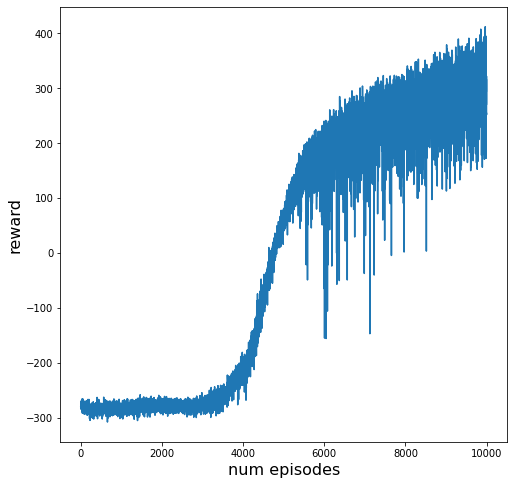

In [73]:
plt.figure(figsize=(8,8))
plt.plot(h)
plt.xlabel("num episodes",fontsize=16)
plt.ylabel("reward",fontsize=16)
plt.show()

## Experiments from Medium

In [ ]:
!pip install ray==1.0.0

     |████████████████████████████████| 22.9MB 1.6MB/s 
     |████████████████████████████████| 3.2MB 40.4MB/s 
     |████████████████████████████████| 81kB 13.5MB/s 
     |████████████████████████████████| 204kB 52.5MB/s 
     |████████████████████████████████| 133kB 56.0MB/s 
     |████████████████████████████████| 1.3MB 48.1MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 296kB 57.1MB/s 
     |████████████████████████████████| 143kB 25.0MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp37-none-any.whl size=12621 sha256=b3e6231a2874c6d96fe2a08d43d957035c4ced2a0a7819db8695c07af77d22f2
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat


In [ ]:
import or_gym
from or_gym.utils import create_env
import ray
from ray.rllib import agents
from ray import tune

Instructions for updating:
non-resource variables are not supported in the long term


lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.


In [ ]:
def register_env(env_name, env_config={}):
    env = create_env(env_name)
    tune.register_env(env_name, 
        lambda env_name: env(env_name,
            env_config=env_config))

In [ ]:
# Environment and RL Configuration Settings
env_name = 'InvManagement-v1'
env_config = {} # Change environment parameters here
rl_config = dict(
    env=env_name,
    num_workers=2,
    env_config=env_config,
    model=dict(
        vf_share_layers=False,
        fcnet_activation='elu',
        fcnet_hiddens=[256, 256]
    ),
   # framework='torch',
    lr=1e-5
)
# Register environment
register_env(env_name, env_config)

In [ ]:
ray.init(ignore_reinit_error=True,)
agent = agents.ppo.PPOTrainer(env=env_name,
    config=rl_config)
print('ok')
results = []
for i in range(500):
    res = agent.train()
    results.append(res)
    if (i+1) % 5 == 0:
        print('\rIter: {}\tReward: {:.2f}'.format(
                i+1, res['episode_reward_mean']), end='')
ray.shutdown()

2021-03-04 08:24:24,798	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265
2021-03-04 08:24:27,000	INFO logger.py:201 -- pip install 'ray[tune]' to see TensorBoard files.
2021-03-04 08:24:27,001	WARNING logger.py:343 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2021-03-04 08:24:27,009	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-03-04 08:24:27,013	INFO trainer.py:618 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=169) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=169) Instructions for updating:
(pid=169) non-resource variables are not supported in the long term
(pid=170) WARNING:tensorflow:From /usr/local/lib/python3.7/di

ok
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


(pid=169) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/ray/rllib/policy/tf_policy.py:874: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=169) Instructions for updating:
(pid=169) Prefer Variable.assign which has equivalent behavior in 2.X.
(pid=170) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/ray/rllib/policy/tf_policy.py:874: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
(pid=170) Instructions for updating:
(pid=170) Prefer Variable.assign which has equivalent behavior in 2.X.


Iter: 25	Reward: -13.56

KeyboardInterrupt: ignored